In [ ]:
%%capture
!pip install pymorphy3
!sudo apt-get update
!sudo apt-get install texlive-latex-recommended
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended

In [ ]:
%%capture
!wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip

In [ ]:
!unzip type1cm.zip -d /tmp/type1cm

Archive:  type1cm.zip
   creating: /tmp/type1cm/type1cm/
  inflating: /tmp/type1cm/type1cm/type1cm.fdd  
  inflating: /tmp/type1cm/type1cm/type1cm.ins  
  inflating: /tmp/type1cm/type1cm/type1cm.txt  
  inflating: /tmp/type1cm/type1cm/type1cm-doc.pdf  
  inflating: /tmp/type1cm/type1cm/type1cm-doc.tex  


In [ ]:
%%capture
!cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins

In [ ]:
%%capture
!sudo mkdir /usr/share/texmf/tex/latex/type1cm
!sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
!sudo texhash
!apt install cm-super

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymorphy3 import MorphAnalyzer
from scipy.stats import chi2_contingency

In [ ]:
sns.set_palette("Dark2")

In [ ]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.size" : 15,
    "text.usetex": False,
    "pgf.rcfonts": False,
    "text.color" : "black"
})

In [ ]:
%matplotlib inline

In [ ]:
reference_df = pd.read_csv("ref_unmasked (1).csv")
bertmlm_df = pd.read_csv("bert_unmasked.csv")
modularmlm_df = pd.read_csv("modular_unmasked.csv")

reference_df = reference_df[reference_df["Sentence with MASK"].str.contains("[MASK]")]
bertmlm_df = bertmlm_df[bertmlm_df["Sentence"].str.contains("[MASK]")]
modularmlm_df = modularmlm_df[modularmlm_df["Sentence"].str.contains("[MASK]")]

In [ ]:
len(reference_df) == len(bertmlm_df) == len(modularmlm_df)

True

In [ ]:
merged_df = pd.DataFrame({"number": range(len(reference_df)),
                         "sentence": reference_df["Sentence with MASK"],
                         "orig_word": reference_df["Original Word"].str.lower().str.strip(),
                         "orig_person": reference_df.Person,
                         "orig_number": reference_df.Number,
                         "bert_pred": bertmlm_df["Predicted Token"].str.lower().str.strip(),
                         "bert_person": bertmlm_df.Person,
                         "bert_number": bertmlm_df.Number,
                         "modular_pred": modularmlm_df["Predicted Token"].str.lower().str.strip(),
                         "modular_person": modularmlm_df.Person,
                         "modular_number": modularmlm_df.Number})

merged_df["bert_fullpred_res"] = merged_df.orig_word == merged_df.bert_pred
merged_df["modular_fullpred_res"] = merged_df.orig_word == merged_df.modular_pred

In [ ]:
morph = MorphAnalyzer()
def get_missing_number(word):
    if not isinstance(word, float):
        tokenized = word.split()
        for token in tokenized:
            parsed_list = morph.parse(token)
            for i in range(len(parsed_list)):
                if parsed_list[i].tag.POS in ["NOUN", "NPRO"]:
                    return parsed_list[i].tag.number
    return float("nan")

def get_missing_person(word):
    if not isinstance(word, float):
        tokenized = word.split()
        for token in tokenized:
            parsed_list = morph.parse(token)
            for i in range(len(parsed_list)):
                if parsed_list[i].tag.POS == "NPRO":
                    return parsed_list[i].tag.person
                elif parsed_list[i].tag.POS == "NOUN":
                    return "3per"
    return float("nan")

In [ ]:
morph.parse("его")[0].tag.POS

'NPRO'

In [ ]:
merged_df["upd_orig_person"] = merged_df.orig_word.apply(get_missing_person)
merged_df["upd_orig_number"] = merged_df.orig_word.apply(get_missing_number)

merged_df["upd_bert_person"] = merged_df.bert_pred.apply(get_missing_person)
merged_df["upd_bert_number"] = merged_df.bert_pred.apply(get_missing_number)

merged_df["upd_modular_person"] = merged_df.modular_pred.apply(get_missing_person)
merged_df["upd_modular_number"] = merged_df.modular_pred.apply(get_missing_number)

In [ ]:
merged_df = merged_df[["upd_orig_person", "upd_orig_number", "upd_bert_person", "upd_bert_number", "upd_modular_person", "upd_modular_number"]]

In [ ]:
merged_df

,upd_orig_person,upd_orig_number,upd_bert_person,upd_bert_number,upd_modular_person,upd_modular_number
0,3per,sing,3per,sing,3per,sing
1,3per,sing,3per,sing,NaN,NaN
2,3per,sing,3per,plur,3per,plur
3,3per,plur,3per,plur,3per,plur
4,3per,sing,NaN,NaN,3per,sing
...,...,...,...,...,...,...
59796,NaN,NaN,3per,sing,2per,plur
59797,3per,sing,3per,sing,3per,sing
59798,3per,sing,3per,sing,3per,sing
59799,1per,sing,3per,plur,1per,sing


In [ ]:
merged_df["bert_correct_person"] = merged_df["upd_bert_person"] == merged_df["upd_orig_person"]
merged_df["modular_correct_person"] = merged_df["upd_modular_person"] == merged_df["upd_orig_person"]

print("=== person predictions accuracy ===")

bert_person_acc = merged_df["bert_correct_person"].mean()
modular_person_acc = merged_df["modular_correct_person"].mean()

print(f"BERT accuracy: {bert_person_acc:.3f}")
print(f"Modular accuracy: {modular_person_acc:.3f}")
print()

bert_counts = merged_df["bert_correct_person"].value_counts().reindex([True, False])
modular_counts = merged_df["modular_correct_person"].value_counts().reindex([True, False])

result_array = np.array([bert_counts.values, modular_counts.values])

print(result_array)

chi2, p_value, dof, expected = chi2_contingency(result_array)
print(f"\n=== chi-square results ===")
print(f"χ² = {chi2:.4f}")
print(f"p-value = {p_value:.4f}")
print(f"Degrees of freedom = {dof}")

=== person predictions accuracy ===
BERT accuracy: 0.610
Modular accuracy: 0.655

[[34627 22103]
 [37132 19598]]

=== chi-square results ===
χ² = 237.7325
p-value = 0.0000
Degrees of freedom = 1


In [ ]:
# first person
partial_df = merged_df.query("upd_orig_person == '1per'").copy()

partial_df["bert_correct_person"] = partial_df["upd_bert_person"] == partial_df["upd_orig_person"]
partial_df["modular_correct_person"] = partial_df["upd_modular_person"] == partial_df["upd_orig_person"]

print("=== 1st person predictions accuracy ===")

bert_1per_acc = partial_df["bert_correct_person"].mean()
modular_1per_acc = partial_df["modular_correct_person"].mean()

print(f"BERT accuracy: {bert_1per_acc:.3f}")
print(f"Modular accuracy: {modular_1per_acc:.3f}")
print()

bert_counts = partial_df["bert_correct_person"].value_counts().reindex([True, False])
modular_counts = partial_df["modular_correct_person"].value_counts().reindex([True, False])

result_array = np.array([bert_counts.values, modular_counts.values])

print(result_array)

chi2, p_value, dof, expected = chi2_contingency(result_array)
print(f"\n=== chi-square results ===")
print(f"χ² = {chi2:.4f}")
print(f"p-value = {p_value:.4f}")
print(f"Degrees of freedom = {dof}")

=== 1st person predictions accuracy ===
BERT accuracy: 0.414
Modular accuracy: 0.515

[[1072 1520]
 [1336 1256]]

=== chi-square results ===
χ² = 53.6415
p-value = 0.0000
Degrees of freedom = 1


In [ ]:
# second person
partial_df = merged_df.query("upd_orig_person == '2per'").copy()

partial_df["bert_correct_person"] = partial_df["upd_bert_person"] == partial_df["upd_orig_person"]
partial_df["modular_correct_person"] = partial_df["upd_modular_person"] == partial_df["upd_orig_person"]

print("=== 2nd person predictions accuracy ===")

bert_2per_acc = partial_df["bert_correct_person"].mean()
modular_2per_acc = partial_df["modular_correct_person"].mean()

print(f"BERT accuracy: {bert_2per_acc:.3f}")
print(f"Modular accuracy: {modular_2per_acc:.3f}")
print()

bert_counts = partial_df["bert_correct_person"].value_counts().reindex([True, False])
modular_counts = partial_df["modular_correct_person"].value_counts().reindex([True, False])

result_array = np.array([bert_counts.values, modular_counts.values])

print(result_array)

chi2, p_value, dof, expected = chi2_contingency(result_array)
print(f"\n=== chi-square results ===")
print(f"χ² = {chi2:.4f}")
print(f"p-value = {p_value:.4f}")
print(f"Degrees of freedom = {dof}")

=== 2nd person predictions accuracy ===
BERT accuracy: 0.240
Modular accuracy: 0.373

[[ 332 1054]
 [ 517  869]]

=== chi-square results ===
χ² = 57.4833
p-value = 0.0000
Degrees of freedom = 1


In [ ]:
# third person
partial_df = merged_df.query("upd_orig_person == '3per'").copy()

partial_df["bert_correct_person"] = partial_df["upd_bert_person"] == partial_df["upd_orig_person"]
partial_df["modular_correct_person"] = partial_df["upd_modular_person"] == partial_df["upd_orig_person"]

print("=== 3d person predictions accuracy ===")

bert_3per_acc = partial_df["bert_correct_person"].mean()
modular_3per_acc = partial_df["modular_correct_person"].mean()

print(f"BERT accuracy: {bert_3per_acc:.3f}")
print(f"Modular accuracy: {modular_3per_acc:.3f}")
print()

bert_counts = partial_df["bert_correct_person"].value_counts().reindex([True, False])
modular_counts = partial_df["modular_correct_person"].value_counts().reindex([True, False])

result_array = np.array([bert_counts.values, modular_counts.values])

print(result_array)

chi2, p_value, dof, expected = chi2_contingency(result_array)
print(f"\n=== chi-square results ===")
print(f"χ² = {chi2:.4f}")
print(f"p-value = {p_value:.4f}")
print(f"Degrees of freedom = {dof}")

=== 3d person predictions accuracy ===
BERT accuracy: 0.740
Modular accuracy: 0.786

[[33223 11670]
 [35279  9614]]

=== chi-square results ===
χ² = 260.0613
p-value = 0.0000
Degrees of freedom = 1


In [ ]:
merged_df["bert_correct_number"] = merged_df["upd_bert_number"] == merged_df["upd_orig_number"]
merged_df["modular_correct_number"] = merged_df["upd_modular_number"] == merged_df["upd_orig_number"]

print("=== number prediction accuracy ===")

bert_number_acc = merged_df["bert_correct_number"].mean()
modular_number_acc = merged_df["modular_correct_number"].mean()

print(f"BERT accuracy: {bert_number_acc:.3f}")
print(f"Modular accuracy: {modular_number_acc:.3f}")
print()

bert_counts = merged_df["bert_correct_number"].value_counts().reindex([True, False])
modular_counts = merged_df["modular_correct_number"].value_counts().reindex([True, False])

result_array = np.array([bert_counts.values, modular_counts.values])

print(result_array)

chi2, p_value, dof, expected = chi2_contingency(result_array)
print(f"\n=== chi-square results ===")
print(f"χ² = {chi2:.4f}")
print(f"p-value = {p_value:.4f}")
print(f"Degrees of freedom = {dof}")

=== number prediction accuracy ===
BERT accuracy: 0.612
Modular accuracy: 0.657

[[34725 22005]
 [37260 19470]]

=== chi-square results ===
χ² = 244.0212
p-value = 0.0000
Degrees of freedom = 1


In [ ]:
# singular number
partial_df = merged_df.query("upd_orig_number == 'sing'").copy()

partial_df["bert_correct_number"] = partial_df["upd_bert_number"] == partial_df["upd_orig_number"]
partial_df["modular_correct_number"] = partial_df["upd_modular_number"] == partial_df["upd_orig_number"]

print("=== singular number predictions accuracy ===")

bert_sing_acc = partial_df["bert_correct_number"].mean()
modular_sing_acc = partial_df["modular_correct_number"].mean()

print(f"BERT accuracy: {bert_sing_acc:.3f}")
print(f"Modular accuracy: {modular_sing_acc:.3f}")
print()

bert_counts = partial_df["bert_correct_number"].value_counts().reindex([True, False])
modular_counts = partial_df["modular_correct_number"].value_counts().reindex([True, False])

result_array = np.array([bert_counts.values, modular_counts.values])

print(result_array)

chi2, p_value, dof, expected = chi2_contingency(result_array)
print(f"\n=== chi-square results ===")
print(f"χ² = {chi2:.4f}")
print(f"p-value = {p_value:.4f}")
print(f"Degrees of freedom = {dof}")

=== singular number predictions accuracy ===
BERT accuracy: 0.737
Modular accuracy: 0.786

[[31956 11382]
 [34050  9288]]

=== chi-square results ===
χ² = 278.3001
p-value = 0.0000
Degrees of freedom = 1


In [ ]:
# plural number
partial_df = merged_df.query("upd_orig_number == 'plur'").copy()

partial_df["bert_correct_number"] = partial_df["upd_bert_number"] == partial_df["upd_orig_number"]
partial_df["modular_correct_number"] = partial_df["upd_modular_number"] == partial_df["upd_orig_number"]

print("=== plural number predictions accuracy ===")

bert_plur_acc = partial_df["bert_correct_number"].mean()
modular_plur_acc = partial_df["modular_correct_number"].mean()

print(f"BERT accuracy: {bert_plur_acc:.3f}")
print(f"Modular accuracy: {modular_plur_acc:.3f}")
print()

bert_counts = partial_df["bert_correct_number"].value_counts().reindex([True, False])
modular_counts = partial_df["modular_correct_number"].value_counts().reindex([True, False])

result_array = np.array([bert_counts.values, modular_counts.values])

print(result_array)

chi2, p_value, dof, expected = chi2_contingency(result_array)
print(f"\n=== chi-square results ===")
print(f"χ² = {chi2:.4f}")
print(f"p-value = {p_value:.4f}")
print(f"Degrees of freedom = {dof}")

=== plural number predictions accuracy ===
BERT accuracy: 0.292
Modular accuracy: 0.338

[[2769 6729]
 [3210 6288]]

=== chi-square results ===
χ² = 47.2529
p-value = 0.0000
Degrees of freedom = 1


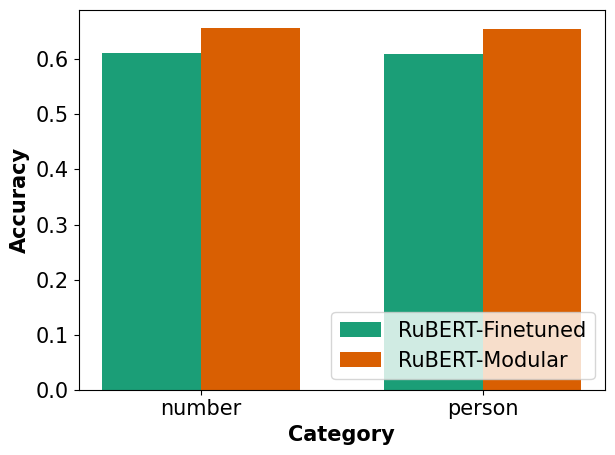

In [ ]:
fig, ax = plt.subplots()
bar_width = 0.35
r1 = np.arange(2)
r2 = [x + bar_width for x in r1]

ax.bar(r1, [bert_number_acc, bert_person_acc], width=bar_width, label="RuBERT-Finetuned")
ax.bar(r2, [modular_number_acc, modular_person_acc], width=bar_width, label="RuBERT-Modular")
plt.xlabel("Category", fontweight="bold")
plt.ylabel("Accuracy", fontweight="bold")
plt.xticks([r + bar_width/2 for r in range(2)], ["number", "person"])

plt.legend(loc="lower right")
plt.tight_layout()
fig.show()

plt.savefig("accuracy.pgf")

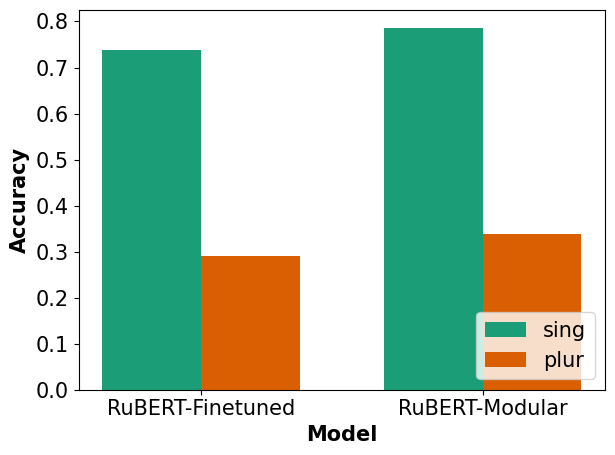

In [ ]:
fig, ax = plt.subplots()
bar_width = 0.35
r1 = np.arange(2)
r2 = [x + bar_width for x in r1]

ax.bar(r1, [bert_sing_acc, modular_sing_acc], width=bar_width, label="sing")
ax.bar(r2, [bert_plur_acc, modular_plur_acc], width=bar_width, label="plur")
plt.xlabel("Model", fontweight="bold")
plt.ylabel("Accuracy", fontweight="bold")
plt.xticks([r + bar_width/2 for r in range(2)], ["RuBERT-Finetuned", "RuBERT-Modular"])

plt.legend(loc="lower right")
plt.tight_layout()
fig.show()

plt.savefig("accuracy_by_number.pgf")

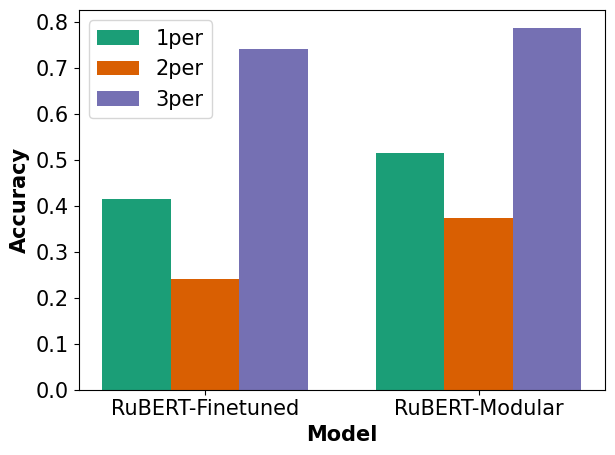

In [ ]:
fig, ax = plt.subplots()
bar_width = 0.25
r1 = np.arange(2)
r2 = [x + bar_width for x in r1]
r3 = [x + 2 * bar_width for x in r1]

ax.bar(r1, [bert_1per_acc, modular_1per_acc], width=bar_width, label="1per")
ax.bar(r2, [bert_2per_acc, modular_2per_acc], width=bar_width, label="2per")
ax.bar(r3, [bert_3per_acc, modular_3per_acc], width=bar_width, label="3per")
plt.xlabel("Model", fontweight="bold")
plt.ylabel("Accuracy", fontweight="bold")
plt.xticks([r + bar_width for r in range(2)], ["RuBERT-Finetuned", "RuBERT-Modular"])

plt.legend()
plt.tight_layout()
fig.show()

plt.savefig("accuracy_by_person.pgf")